# 異種混合なグラフでの実践

- **Original**: https://docs.dgl.ai/en/latest/tutorials/basics/5_hetero.html
- **Orig. Author**: Quan Gan, Minjie Wang, Mufei Li, George Karypis, Zheng Zhang
- **Author**: Junya Yamaguchi (openjny)
- **Date**: 2020/01/30

このチュートリアル学ぶことは:

- heterogeneous (異種混合な) グラフの例とその典型的な応用例
- DGL で異種グラフを作成/処理する方法
- Relational-GCN と呼ばれる、異種グラフを入力できる有名な手法の実装
- ノード分類タスクを解くモデルの学習

Heterogeneous グラフ (heterograph とも言う。日本語では異種グラフ？) は、異なるタイプのノードやエッジを有するグラフのことです。種類に応じた特徴が現れていると考えると、ノード/エッジの種類が違えば、その特徴の種類も違うとみなすのが自然です。グラフニューラルネットワーク (GNN) の観点から見れば、各ノード/エッジで次元が異なる特徴ベクトルを扱えようにする要請を意味します。

DGL では、そのような異種グラフに対する GNN をサポートするため、heterograph クラスと関連 API を提供しています。

## 異種グラフの例

グラフのデータセットは、様々なエンティティ種類の関係を表す場合が多いです。このセクションでは、そんな関係を表現するいくつかのグラフを紹介し、それらが heterograph として実装出来ることを見ます。

### 引用グラフ

ACM (association for computing machinery) は ACM データセットを公開しています。ACM データセットは、200 万の論文、その著者、学会、そして引用されている他の論文から成ります。この情報は、異種グラフとして表現可能です。

以下の図は、ACM データセットのいくつかのエンティティと、それらの関係を示した図です (Shi et al. 2015 より)。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/hetero/acm-example.png#)

まず、エンティティには paper, author, publication venue の 3 種類あることがわかります。さらに、エッジに関しても、以下の 3 つの種類が存在します。

- 著者=論文: `written-by` 関係
- 論文=学会: `published-in` 関係
- 論文=論文: `cited-by` 関係

### 推薦システム

推薦システム (recommender system) で使われるデータセットも、しばしば、ユーザーとアイテムの関係を保有することがあります。例えば、映画に対してユーザーが付けたレーティングのデータもあり得ます。そのような関係は heterograph としてモデリングできます。

この種の heterograph のノードは 2 つの種類を持ちます (e.g. ユーザーと映画)。エッジは、ユーザーと映画の相互関係に対応していて、例えばレーティングとして相互関係を記せば、各エッジ種別がレーティングの得点と対応付けられます。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/hetero/recsys-example.png)

### 知識グラフ

知識グラフ (knowledge graph) は原理的に heterogeneous です。例えば、Wikidata では、バラク・オバマは、(エンティティクラスとみなせる) "人間" のインスタンスであり、配偶者は Michelle Obama、職業は政治家です。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/hetero/kg-example.png)

## 異種グラフを DGL で作成

`dgl.heterograph()` API を使って、DGL では異種グラフを作成することが出来ます。クラスのインスタンス化の際に指定する引数は、連想マップ `dict` です。

- key は `(srctype, edgetype, dsttype)` の形をした `str` の 3-タプルで、エッジの種類を定義します。
- value は、ノード ID ペアをリストで指定します。value で指定したノード間に、key の種類のエッジが貼られ、そのノード種別は key で指定したものになるイメージです。

In [1]:
import dgl

ratings = dgl.heterograph(
    {('user', '+1', 'movie') : [(0, 0), (0, 1), (1, 0)],
     ('user', '-1', 'movie') : [(2, 1)]})

DGL は様々なデータソースからのグラフ作成に対応しています。以下のコードは、先程の例と全く同じグラフを作成します

In [2]:
# scipy sparse matrix から
import scipy.sparse as sp
plus1 = sp.coo_matrix(([1, 1, 1], ([0, 0, 1], [0, 1, 0])), shape=(3, 2))
minus1 = sp.coo_matrix(([1], ([2], [1])), shape=(3, 2))
ratings = dgl.heterograph({
    ('user', '+1', 'movie'): plus1,
    ('user', '-1', 'movie'): minus1
})

# networkx から
import networkx as nx
plus1 = nx.DiGraph()
plus1.add_nodes_from(['u0', 'u1', 'u2'], bipartite=0)
plus1.add_nodes_from(['m0', 'm1'], bipartite=1)
plus1.add_edges_from([('u0', 'm0'), ('u0', 'm1'), ('u1', 'm0')])
ratings = dgl.heterograph({
    ('user', '+1', 'movie') : plus1,
    ('user', '-1', 'movie') : minus1
})

# エッジリストから
ratings = dgl.heterograph({
    ('user', '+1', 'movie') : ([0, 0, 1], [0, 1, 0]),
    ('user', '-1', 'movie') : ([2], [1])
})

## heterograph の操作

ACM データセットを使って、もっと実際のデータ分析の現場で使われるようなものに近い heterograph を作成できます。まずは ACM データセットをダウンロードします。

In [3]:
import scipy.io
import urllib.request
import os

data_url = 'https://s3.us-east-2.amazonaws.com/dgl.ai/dataset/ACM.mat'
data_file_path = '/tmp/ACM.mat'

if not os.path.isfile(data_file_path):
    urllib.request.urlretrieve(data_url, data_file_path)
data = scipy.io.loadmat(data_file_path)
print(list(data.keys()))

['__header__', '__version__', '__globals__', 'TvsP', 'PvsA', 'PvsV', 'AvsF', 'VvsC', 'PvsL', 'PvsC', 'A', 'C', 'F', 'L', 'P', 'T', 'V', 'PvsT', 'CNormPvsA', 'RNormPvsA', 'CNormPvsC', 'RNormPvsC', 'CNormPvsT', 'RNormPvsT', 'CNormPvsV', 'RNormPvsV', 'CNormVvsC', 'RNormVvsC', 'CNormAvsF', 'RNormAvsF', 'CNormPvsL', 'RNormPvsL', 'stopwords', 'nPvsT', 'nT', 'CNormnPvsT', 'RNormnPvsT', 'nnPvsT', 'nnT', 'CNormnnPvsT', 'RNormnnPvsT', 'PvsP', 'CNormPvsP', 'RNormPvsP']


データセットの `A, C, F, L, P, T, V` はノードの種類を表しています。そのうち、チュートリアルに関係がある 3 つの種類を簡単に説明します。

- `P`: 論文 (paper)
- `A`: 著者 (author)
- `C`: 学会 (conference)
- `L`: ジャンル (subject code)

`{node_type_1}vs{node_type_2}` のような key に対応する value は、エッジのリストを表しています。

例として、paper-author (written-by) 関係の統計量をいくつかだしてみます。

In [4]:
print(type(data['PvsA']))
print('shape:', data['PvsA'].shape)
print('#Papers:', data['PvsA'].shape[0])
print('#Authors:', data['PvsA'].shape[1])
print('#Links:', data['PvsA'].nnz)

<class 'scipy.sparse.csc.csc_matrix'>
shape: (12499, 17431)
#Papers: 12499
#Authors: 17431
#Links: 37055


SciPy 行列を DGL の heterograph に変換するのは簡単です。

In [5]:
pa_g = dgl.heterograph({('paper', 'written-by', 'author') : data['PvsA']})
# 2 種類のノードを持つ異種グラフのための糖衣構文
pa_g = dgl.bipartite(data['PvsA'], 'paper', 'written-by', 'author')

In [6]:
print('Node types:', pa_g.ntypes)
print('Edge types:', pa_g.etypes)
print('Canonical edge types:', pa_g.canonical_etypes)

Node types: ['paper', 'author']
Edge types: ['written-by']
Canonical edge types: [('paper', 'written-by', 'author')]


In [7]:
# ノードは「種類ごとに」0 から始まるインデックスが付与される
print('#nodes of paper:', pa_g.number_of_nodes('paper'))
print('#nodes of author:', pa_g.number_of_nodes('author'))

# もしエッジの種類名だけで一意に 3-tuple が特定できる場合は、canonical な書き方をしなくてもよい
print(pa_g.number_of_edges(('paper', 'written-by', 'author')))
print(pa_g.number_of_edges('written-by'))
print(pa_g.number_of_edges()) # エッジ種別が一つしかない場合は、種別名を省略することが出来る

# [paper] --- written-by ---> [author]
#    1                       successors
print('Authors wrote the paper 1:', pa_g.successors(1, etype='written-by'))

# [paper] --- written-by ---> [author]
# predecessor                   3532
print('Papers wrriten-by the author 3532:', pa_g.predecessors(3532, etype='written-by')) 


#nodes of paper: 12499
#nodes of author: 17431
37055
37055
37055
Authors wrote the paper 1: tensor([3532, 6421, 8516, 8560])
Papers wrriten-by the author 3532: tensor([    1,  2615,  3893,  9416, 11626])


homogeneous (同種) グラフは異種グラフの特別なケース似すぎないので、異種グラフとして表現された同種グラフは `DGLGraph` と同じ API で扱えます。

In [8]:
# 同種グラフを敢えて異種グラフとして表現
pp_g = dgl.heterograph({('paper', 'citing', 'paper') : data['PvsP']})

# 👆 の糖衣構文
# pp_g = dgl.graph(data['PvsP'], 'paper', 'cite')

print(pp_g.number_of_nodes())
print(pp_g.number_of_edges())
print(pp_g.successors(3))

12499
30789
tensor([1361, 2624, 8670, 9845])


API の紹介はここまでにして、いよいよ ACM データから異種グラフを作ります。後のセクションの準備の為に、反対の関係のエッジも定義しておきます。

In [9]:
G = dgl.heterograph({
        ('paper', 'written-by', 'author') : data['PvsA'],
        ('author', 'writing', 'paper') : data['PvsA'].transpose(),
        ('paper', 'citing', 'paper') : data['PvsP'],
        ('paper', 'cited', 'paper') : data['PvsP'].transpose(),
        ('paper', 'is-about', 'subject') : data['PvsL'],
        ('subject', 'has', 'paper') : data['PvsL'].transpose(),
    })

print(G)

Graph(num_nodes={'paper': 12499, 'author': 17431, 'subject': 73},
      num_edges={('paper', 'written-by', 'author'): 37055, ('author', 'writing', 'paper'): 37055, ('paper', 'citing', 'paper'): 30789, ('paper', 'cited', 'paper'): 30789, ('paper', 'is-about', 'subject'): 12499, ('subject', 'has', 'paper'): 12499},
      metagraph=[('paper', 'author'), ('paper', 'paper'), ('paper', 'paper'), ('paper', 'subject'), ('author', 'paper'), ('subject', 'paper')])


**メタグラフ (metagraph)** またはネットワーク スキーマは、異種グラフの良い要約です。

DGL ではメタグラフを簡単に利用でき、外部ツールによる可視化等の用途に使えます。

In [10]:
import pygraphviz as pgv
def plot_graph(nxg, filename):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw(filename)

plot_graph(G.metagraph, './output/acm_metagraph.png')

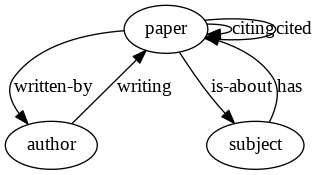

In [11]:
from IPython.display import Image
Image(filename='./output/acm_metagraph.png')

## 異種グラフ関連のタスク設定

異種グラフに関わる典型的な問題には、次のようなものがあります。

- **ノード分類/回帰 (node classification/regression)**: ノードに対応するラベルまたは実数値を予測する問題
- **リンク予測 (link prediction)**: エッジの種類とノード対を与えた時に、そのノード間にエッジが存在するか判定する二値分類問題
- **グラフ分類/回帰 (graph classification/regression)**: 異種グラフ全体に対するラベルまたは実数値を予測する問題

### 半教師付きのノード分類問題

このチュートリアルでは、ノード分類の単純な問題を扱います。目的は、たった今作った ACM アカデミックグラフを用いて、論文の出版した会議を予測することです。

よりタスクをシンプルにするために、KDD, ICML, VLDB の 3つの学会に出版された論文だけにスポットライトを当てます。その他の学会に出版された論文はラベル付けされていないので、**半教師あり (semi-supervised)** のセッティングとなります。

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

pvc = data['PvsC'].tocsr()

# KDD, ICML, VLDB のすべての論文
c_selected = [0, 11, 13]
p_selected = pvc[:, c_selected].tocoo()

# ラベルの生成
labels = np.full_like(pvc.indices, len(c_selected))
for i, c in enumerate(c_selected):
    labels[pvc.indices == c] = i
labels = torch.tensor(labels).long()

pid = p_selected.row
shuffle = np.random.permutation(pid)
train_idx = torch.tensor(shuffle[0:800]).long()
val_idx = torch.tensor(shuffle[800:900]).long()
test_idx = torch.tensor(shuffle[900:]).long()

### 異種グラフ上の Relational-GCN

異種グラフのノード表現を学習するために [Relational-GCN](https://arxiv.org/abs/1703.06103) と呼ばれる手法を使います。Relational-GCN のメッセージパッシングは、次の式で表現されます。

$$
h_i^{(l+1)} = \sigma\left(\sum_{r\in \mathcal{R}}  \sum_{j\in\mathcal{N}_r(i)}W_r^{(l)}h_j^{(l)}\right)
$$

数式を紐解くと、大きく 2 つのパートで構成されていることがわかります。

1. 各関係 (エッジ種類) $r$ に対し、メッセージ伝播と集約を行う
2. 各関係で得られた結果をマージする

この感覚に従って、メッセージパッシングの実装も 2 つのステップに分割出来ます。

1. エッジ種類ごとの message
2. 種類方向の reduce

In [13]:
import dgl.function as fn

class HeteroRGCNLayer(nn.Module):
    def __init__(self, in_size, out_size, etypes):
        super(HeteroRGCNLayer, self).__init__()
        
        # エッジ種類ごとの W_r
        # 出力次元を同じに揃えることで reduction (sum, ave, etc) を容易にする
        self.weight = nn.ModuleDict({
            name : nn.Linear(in_size, out_size) for name in etypes
        })
        
    def forward(self, G, feat_dict):
        """
        G:          heterograph
        feat_dict:  各エッジ種類ごとのノード特徴量の dict
                    `feat_dict[ntype]` で (n_nodes, n_feats) の潜在表現行列が取れるイメージ
        """
        
        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            # W_r * h
            Wh = self.weight[etype](feat_dict[srctype])
            # メッセージパッシングのために ndata に記録
            G.nodes[srctype].data['Wh_%s' % etype] = Wh
            # エッジ種別ごとに (message_func, reduce_func) を作成
            funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
            
        G.multi_update_all(funcs, 'sum')
        
        # 更新された feat_dict を出力
        return {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}

`HeteroRGCNLayer` を 2 層重ねて簡単な GNN を作ります。ノードは入力に特徴量を持たないので、学習可能な embedding を与えます。

In [14]:
class HeteroRGCN(nn.Module):
    def __init__(self, G, in_size, hidden_size, out_size):
        super(HeteroRGCN, self).__init__()
        # 各ノードの特徴は存在しないので、学習可能な embedding を与える
        embed_dict = {
            ntype: nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), in_size))
            for ntype in G.ntypes
        }
        
        for key, embed in embed_dict.items():
            nn.init.xavier_uniform_(embed)
            
        self.embed = nn.ParameterDict(embed_dict)
        self.layer1 = HeteroRGCNLayer(in_size, hidden_size, G.etypes)
        self.layer2 = HeteroRGCNLayer(hidden_size, out_size, G.etypes)
        
    def forward(self, G):
        h_dict = self.layer1(G, self.embed)
        h_dict = {ntype: F.leaky_relu(h) for ntype, h in h_dict.items()}
        
        h_dict = self.layer2(G, h_dict)
        return h_dict['paper']

### 学習と評価

In [15]:
# Create the model. The output has three logits for three classes.
model = HeteroRGCN(G, 10, 10, 3)

opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

best_val_acc = 0
best_test_acc = 0

for epoch in range(100):
    logits = model(G)
    # The loss is computed only for labeled nodes.
    loss = F.cross_entropy(logits[train_idx], labels[train_idx])

    pred = logits.argmax(1)
    train_acc = (pred[train_idx] == labels[train_idx]).float().mean()
    val_acc = (pred[val_idx] == labels[val_idx]).float().mean()
    test_acc = (pred[test_idx] == labels[test_idx]).float().mean()

    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 5 == 0:
        print('[%3d] Loss %.4f, Train Acc %.4f, Val Acc %.4f (Best %.4f), Test Acc %.4f (Best %.4f)' % (
            epoch,
            loss.item(),
            train_acc.item(),
            val_acc.item(),
            best_val_acc.item(),
            test_acc.item(),
            best_test_acc.item(),
        ))

[  0] Loss 1.1026, Train Acc 0.2763, Val Acc 0.3500 (Best 0.3500), Test Acc 0.2688 (Best 0.2688)
[  5] Loss 0.9226, Train Acc 0.5088, Val Acc 0.4900 (Best 0.4900), Test Acc 0.5067 (Best 0.4849)
[ 10] Loss 0.7502, Train Acc 0.6450, Val Acc 0.5800 (Best 0.5800), Test Acc 0.5712 (Best 0.5712)
[ 15] Loss 0.5418, Train Acc 0.8913, Val Acc 0.7400 (Best 0.7400), Test Acc 0.7144 (Best 0.6943)
[ 20] Loss 0.3342, Train Acc 0.9425, Val Acc 0.7500 (Best 0.7500), Test Acc 0.7353 (Best 0.7286)
[ 25] Loss 0.1978, Train Acc 0.9663, Val Acc 0.7900 (Best 0.7900), Test Acc 0.7638 (Best 0.7638)
[ 30] Loss 0.1280, Train Acc 0.9700, Val Acc 0.7900 (Best 0.7900), Test Acc 0.7647 (Best 0.7638)
[ 35] Loss 0.0949, Train Acc 0.9712, Val Acc 0.7700 (Best 0.7900), Test Acc 0.7655 (Best 0.7638)
[ 40] Loss 0.0779, Train Acc 0.9725, Val Acc 0.8000 (Best 0.8000), Test Acc 0.7663 (Best 0.7663)
[ 45] Loss 0.0677, Train Acc 0.9725, Val Acc 0.8000 (Best 0.8000), Test Acc 0.7613 (Best 0.7663)
[ 50] Loss 0.0595, Train Acc 0

In [16]:
logits.shape

torch.Size([12499, 3])

In [17]:
logits[train_idx].shape

torch.Size([800, 3])

## 次は？

- DGL 公式の Relational-GCN 実装を見る
- 他のモデルを調べる
    - [Graph Convolutional Matrix Completion](https://github.com/dmlc/dgl/tree/v0.4.0/examples/mxnet/gcmc)
    - [Heterogeneous Graph Attention Network](https://arxiv.org/abs/1903.07293)
    - [Metapath2](https://dl.acm.org/citation.cfm?id=3098036)
- [Heterograph の API リファレンス](https://docs.dgl.ai/en/latest/api/python/heterograph.html) を見る

## Appendix: DGL 公式の Relational-GCN 実装

[dgl/examples/pytorch/rgcn-hetero at master · dmlc/dgl](https://github.com/dmlc/dgl/tree/master/examples/pytorch/rgcn-hetero)

In [18]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

class RelGraphConvHetero(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : int
        Relation names.
    regularizer : str
        Which weight regularizer to use "basis" or "bdd"
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 regularizer="basis",
                 num_bases=None,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvHetero, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_rels = len(rel_names)
        self.regularizer = regularizer
        self.num_bases = num_bases
        if self.num_bases is None or self.num_bases > self.num_rels or self.num_bases < 0:
            self.num_bases = self.num_rels
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop

        if regularizer == "basis":
            # add basis weights
            self.weight = nn.Parameter(th.Tensor(self.num_bases, self.in_feat, self.out_feat))
            if self.num_bases < self.num_rels:
                # linear combination coefficients
                self.w_comp = nn.Parameter(th.Tensor(self.num_rels, self.num_bases))
            nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
            if self.num_bases < self.num_rels:
                nn.init.xavier_uniform_(self.w_comp,
                                        gain=nn.init.calculate_gain('relu'))
        else:
            raise ValueError("Only basis regularizer is supported.")

        # bias
        if self.bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        self.dropout = nn.Dropout(dropout)

    def basis_weight(self):
        """Message function for basis regularizer"""
        if self.num_bases < self.num_rels:
            # generate all weights from bases
            weight = self.weight.view(self.num_bases,
                                      self.in_feat * self.out_feat)
            weight = th.matmul(self.w_comp, weight).view(
                self.num_rels, self.in_feat, self.out_feat)
        else:
            weight = self.weight
        return {self.rel_names[i] : w.squeeze(0) for i, w in enumerate(th.split(weight, 1, dim=0))}

    def forward(self, g, xs):
        """ Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        xs : list of torch.Tensor
            Node feature for each node type.
        Returns
        -------
        list of torch.Tensor
            New node features for each node type.
        """
        g = g.local_var()
        for i, ntype in enumerate(g.ntypes):
            g.nodes[ntype].data['x'] = xs[i]
        ws = self.basis_weight()
        funcs = {}
        for i, (srctype, etype, dsttype) in enumerate(g.canonical_etypes):
            g.nodes[srctype].data['h%d' % i] = th.matmul(
                g.nodes[srctype].data['x'], ws[etype])
            funcs[(srctype, etype, dsttype)] = (fn.copy_u('h%d' % i, 'm'), fn.mean('m', 'h'))
        # message passing
        g.multi_update_all(funcs, 'sum')

        hs = [g.nodes[ntype].data['h'] for ntype in g.ntypes]
        for i in range(len(hs)):
            h = hs[i]
            # apply bias and activation
            if self.self_loop:
                h = h + th.matmul(xs[i], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            h = self.dropout(h)
            hs[i] = h
        return hs

In [19]:
class RelGraphConvHeteroEmbed(nn.Module):
    r"""Embedding layer for featureless heterograph."""
    def __init__(self,
                 embed_size,
                 g,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvHeteroEmbed, self).__init__()
        self.embed_size = embed_size
        self.g = g
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop

        # create weight embeddings for each node for each relation
        self.embeds = nn.ParameterList()
        for srctype, etype, dsttype in g.canonical_etypes:
            embed = nn.Parameter(th.Tensor(g.number_of_nodes(srctype), self.embed_size))
            nn.init.xavier_uniform_(embed, gain=nn.init.calculate_gain('relu'))
            self.embeds.append(embed)

        # bias
        if self.bias:
            self.h_bias = nn.Parameter(th.Tensor(embed_size))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.self_embeds = nn.ParameterList()
            for ntype in g.ntypes:
                embed = nn.Parameter(th.Tensor(g.number_of_nodes(ntype), embed_size))
                nn.init.xavier_uniform_(embed,
                                        gain=nn.init.calculate_gain('relu'))
                self.self_embeds.append(embed)

        self.dropout = nn.Dropout(dropout)

    def forward(self):
        """ Forward computation
        Returns
        -------
        torch.Tensor
            New node features.
        """
        g = self.g.local_var()
        funcs = {}
        for i, (srctype, etype, dsttype) in enumerate(g.canonical_etypes):
            g.nodes[srctype].data['embed-%d' % i] = self.embeds[i]
            funcs[(srctype, etype, dsttype)] = (fn.copy_u('embed-%d' % i, 'm'), fn.mean('m', 'h'))
        g.multi_update_all(funcs, 'sum')
        
        hs = [g.nodes[ntype].data['h'] for ntype in g.ntypes]
        for i in range(len(hs)):
            h = hs[i]
            # apply bias and activation
            if self.self_loop:
                h = h + self.self_embeds[i]
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            h = self.dropout(h)
            hs[i] = h
        return hs

In [20]:
class EntityClassify(nn.Module):
    def __init__(self,
                 g,
                 h_dim, out_dim,
                 num_bases,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(EntityClassify, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
        self.num_bases = None if num_bases < 0 else num_bases
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop

        self.embed_layer = RelGraphConvHeteroEmbed(
            self.h_dim, g, activation=F.relu, self_loop=self.use_self_loop,
            dropout=self.dropout)
        self.layers = nn.ModuleList()
        # h2h
        for i in range(self.num_hidden_layers):
            self.layers.append(RelGraphConvHetero(
                self.h_dim, self.h_dim, self.rel_names, "basis",
                self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                dropout=self.dropout))
        # h2o
        self.layers.append(RelGraphConvHetero(
            self.h_dim, self.out_dim, self.rel_names, "basis",
            self.num_bases, activation=partial(F.softmax, dim=1),
            self_loop=self.use_self_loop))

    def forward(self):
        h = self.embed_layer()
        for layer in self.layers:
            h = layer(self.g, h)
        return h

In [21]:
import pandas as pd
model = EntityClassify(G,
                       h_dim=16,
                       out_dim=3,
                       num_bases=-1, # フィルター (W_r) の数 (-1 => すべて利用)
                       num_hidden_layers=1,
                       dropout=0,
                       use_self_loop=False)
optimizer = th.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

NTYPE_PAPER = 0

model.train()
logs = pd.DataFrame()

for epoch in range(80):
    optimizer.zero_grad()
    logits = model()[NTYPE_PAPER]
    loss = F.cross_entropy(logits[train_idx], labels[train_idx])
    loss.backward()
    optimizer.step()
    
    # logging
    pred = logits.argmax(1)
    train_loss = loss.item()
    train_acc = (pred[train_idx] == labels[train_idx]).float().mean().item()
    val_acc = (pred[val_idx] == labels[val_idx]).float().mean().item()
    val_loss = F.cross_entropy(logits[val_idx], labels[val_idx]).item()
    
    logs = logs.append(pd.Series({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }), ignore_index=True)
        
    if epoch % 5 == 0:
        print('[%3d] {train: {loss=%.4f, acc=%.4f}, val: {loss=%.4f, acc=%.4f}' % (
            epoch,
            train_loss,
            train_acc,
            val_loss,
            val_acc,
        ))

[  0] {train: {loss=1.0970, acc=0.3375}, val: {loss=1.0978, acc=0.3000}
[  5] {train: {loss=1.0019, acc=0.5088}, val: {loss=1.0131, acc=0.4900}
[ 10] {train: {loss=0.9502, acc=0.5200}, val: {loss=0.9745, acc=0.5000}
[ 15] {train: {loss=0.8569, acc=0.6988}, val: {loss=0.9085, acc=0.5900}
[ 20] {train: {loss=0.7224, acc=0.9225}, val: {loss=0.8027, acc=0.8000}
[ 25] {train: {loss=0.6340, acc=0.9600}, val: {loss=0.7424, acc=0.8400}
[ 30] {train: {loss=0.5956, acc=0.9862}, val: {loss=0.7334, acc=0.8500}
[ 35] {train: {loss=0.5805, acc=0.9950}, val: {loss=0.7354, acc=0.8400}
[ 40] {train: {loss=0.5739, acc=0.9962}, val: {loss=0.7295, acc=0.8500}
[ 45] {train: {loss=0.5703, acc=0.9962}, val: {loss=0.7280, acc=0.8400}
[ 50] {train: {loss=0.5679, acc=0.9962}, val: {loss=0.7255, acc=0.8300}
[ 55] {train: {loss=0.5663, acc=0.9962}, val: {loss=0.7254, acc=0.8300}
[ 60] {train: {loss=0.5649, acc=0.9962}, val: {loss=0.7256, acc=0.8300}
[ 65] {train: {loss=0.5640, acc=0.9962}, val: {loss=0.7263, acc=

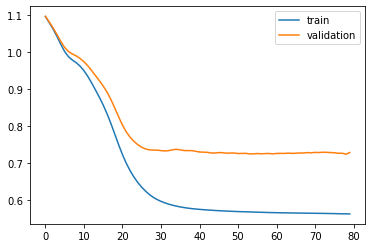

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(logs['train_loss'], label='train')
plt.plot(logs['val_loss'], label='validation')
plt.legend()
plt.show()

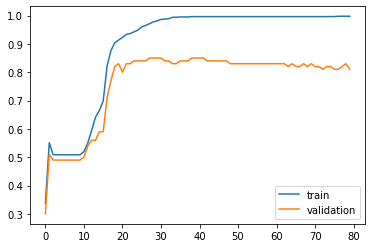

In [23]:
plt.plot(logs['train_acc'], label='train')
plt.plot(logs['val_acc'], label='validation')
plt.legend()
plt.show()

In [24]:
model.eval()
logits = model.forward()[NTYPE_PAPER]
test_loss = F.cross_entropy(logits[test_idx], labels[test_idx]).item()
test_acc = th.sum(logits[test_idx].argmax(dim=1) == labels[test_idx]).item() / len(test_idx)

print("Test Acc: {:.4f} | Test loss: {:.4f}".format(test_acc, test_loss))

Test Acc: 0.8065 | Test loss: 0.7517


先程の例の R-GCN 実装では 100 エポックで `acc=0.78` 付近だったので、DGL (公式) 実装のほうが精度がでていることがわかる。

In [25]:
from torchviz import make_dot
dot = make_dot(logits)
dot.format = 'png'
dot.render('output/canonical_rgcn')

'output/canonical_rgcn.png'

In [26]:
!rm output/canonical_rgcn

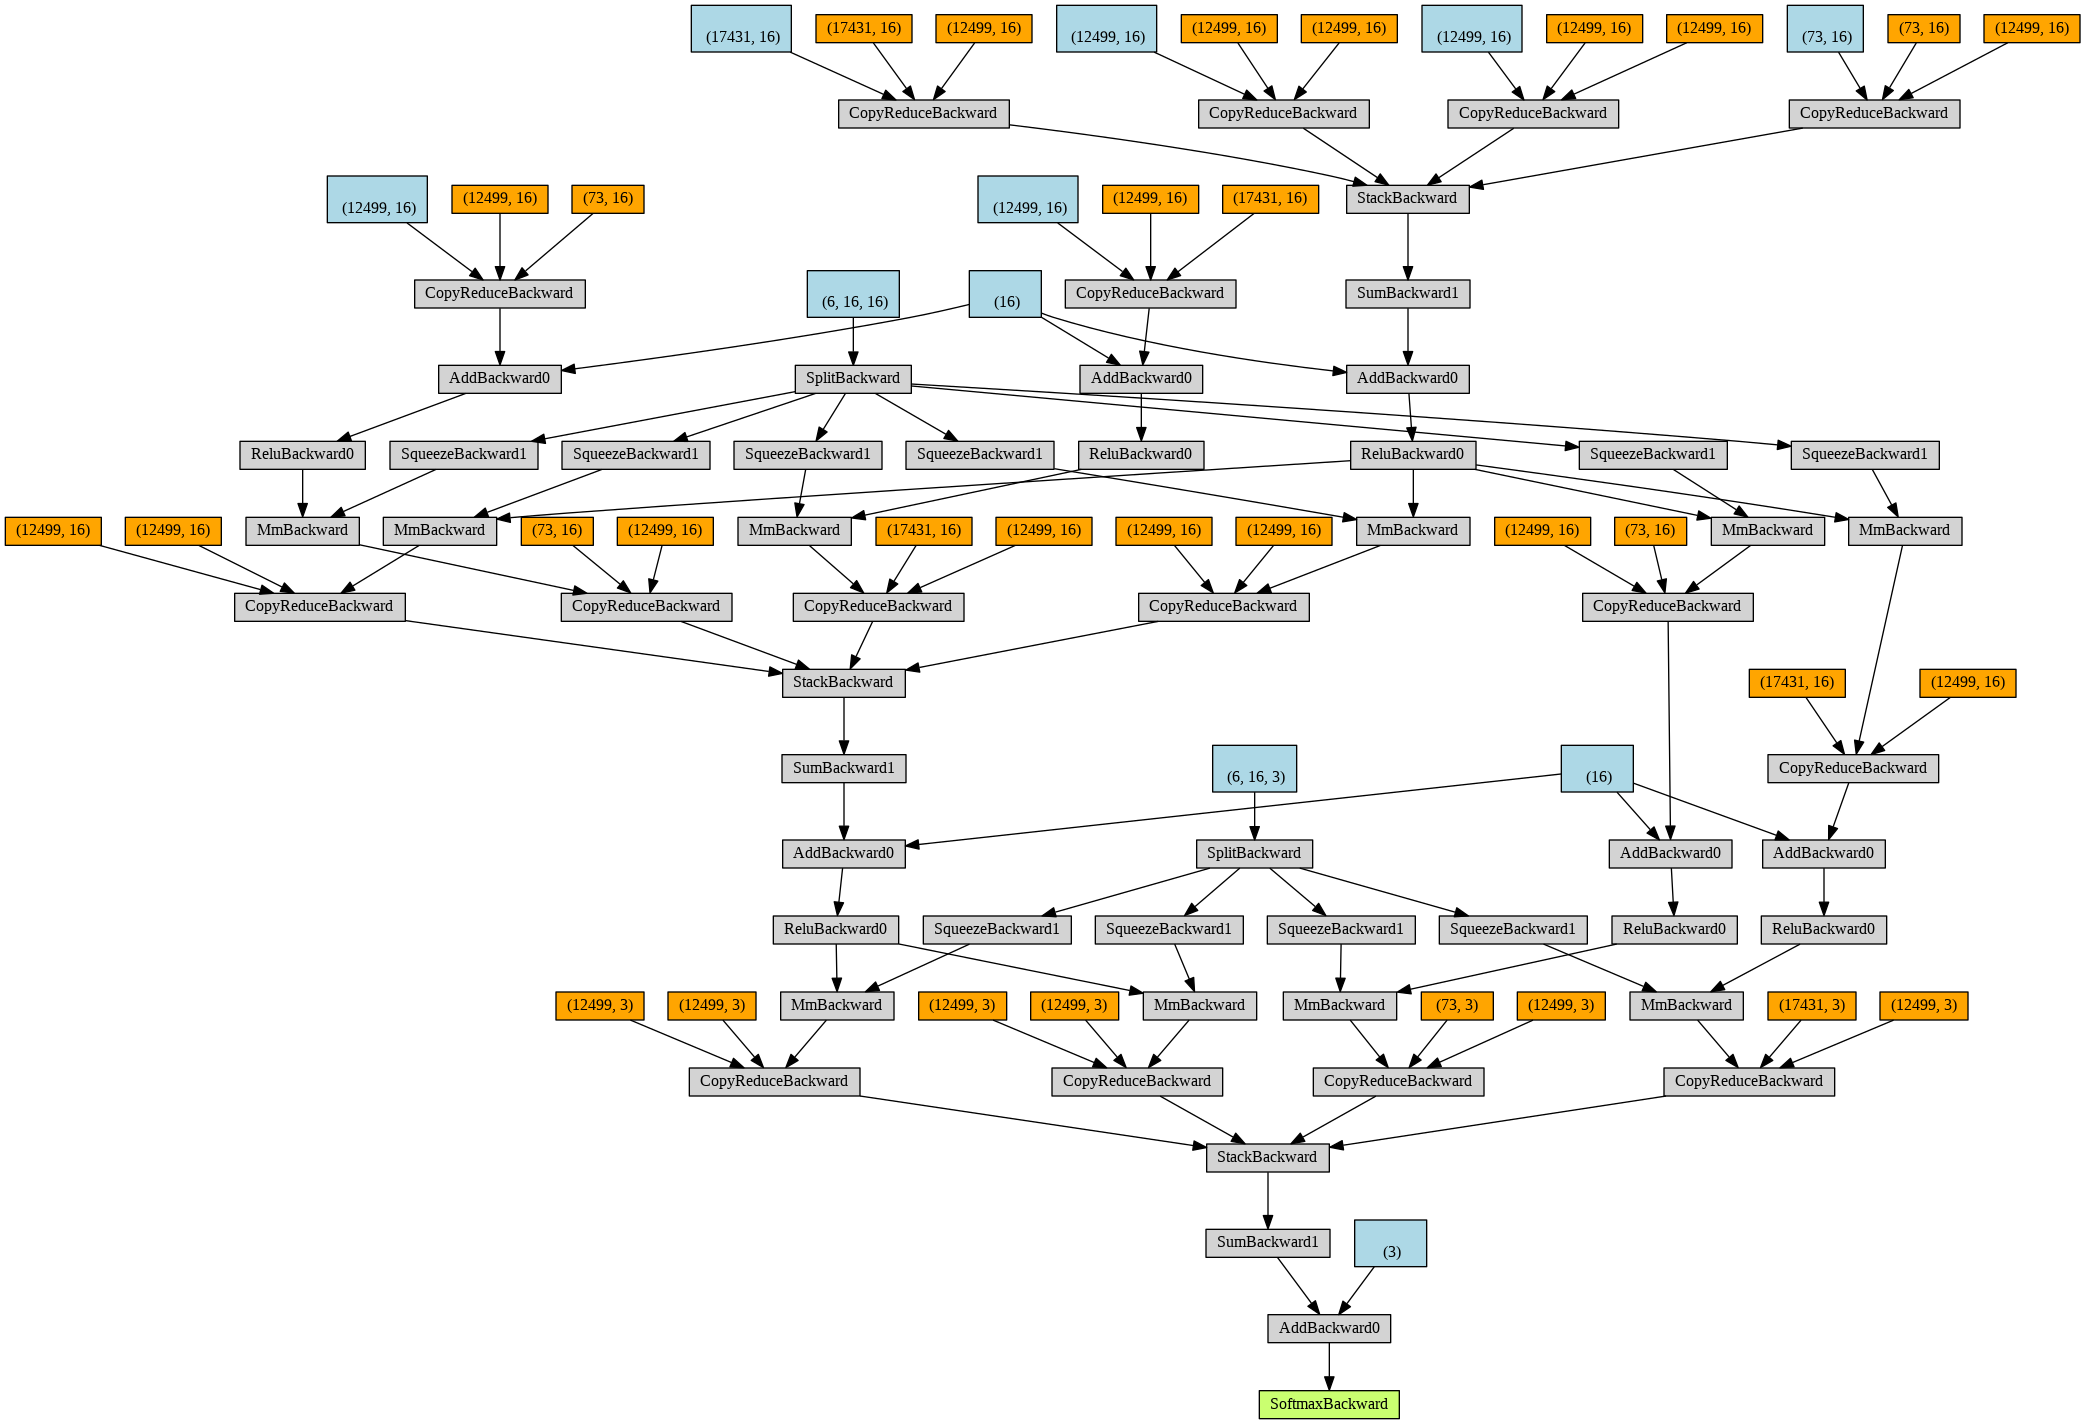

In [27]:
from IPython.display import Image
Image(filename='./output/canonical_rgcn.png')